# PUDL_27 AI CUP 2025 秋季賽-電腦斷層主動脈瓣物件偵測-預測結果
https://tbrain.trendmicro.com.tw/Competitions/Details/42

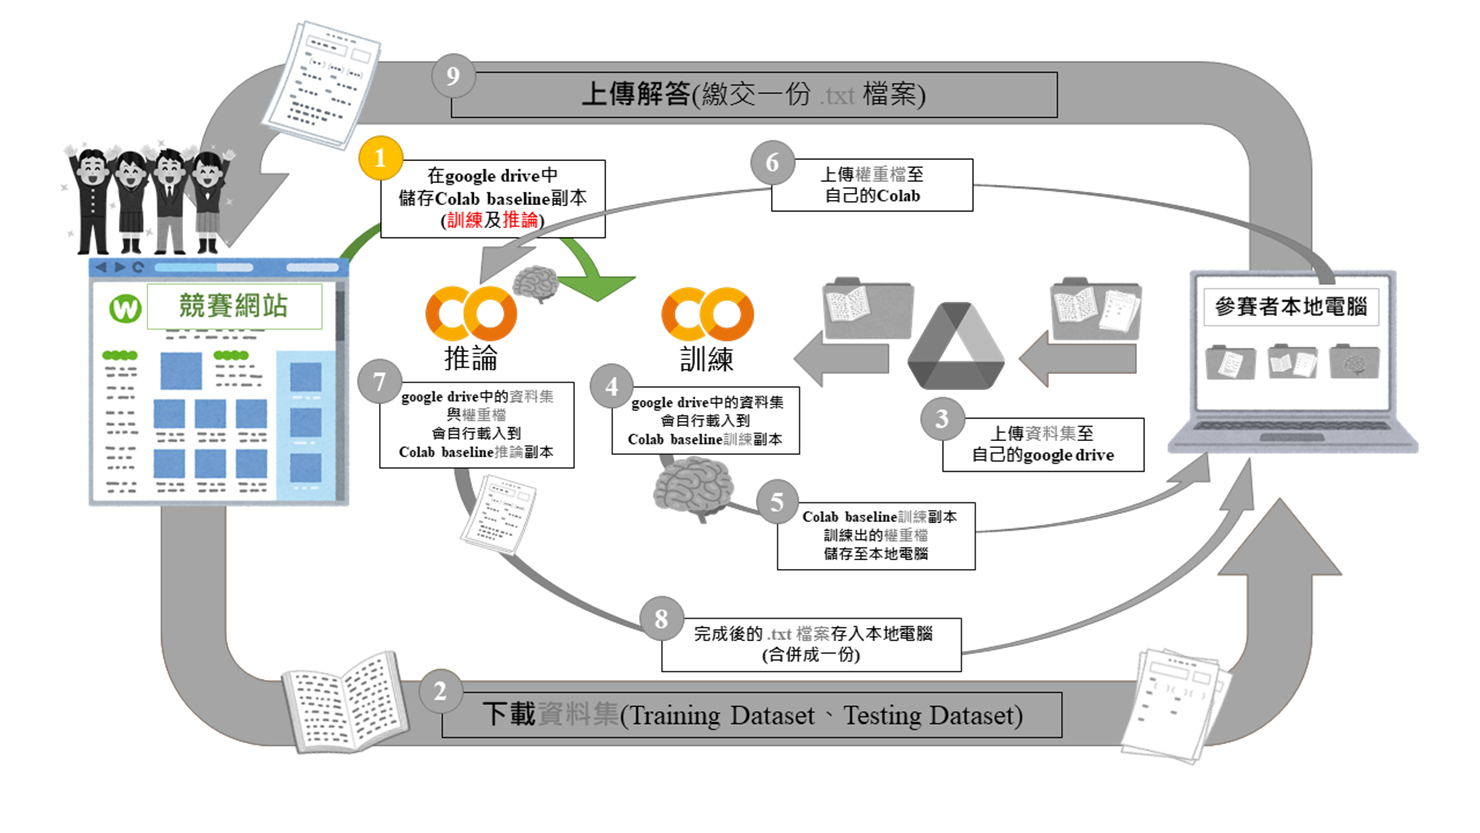

## 1.設置環境

確認有GPU

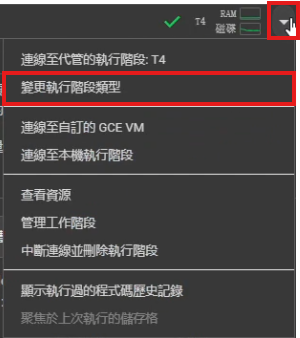
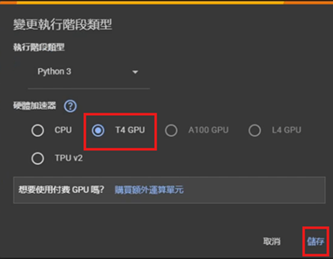

### 查看GPU資訊(運行時間<1秒)

In [ ]:
!nvidia-smi

### 確保不會出現編碼錯誤

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### 下載YOLOv12套件

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

 ## 2.下載資料集

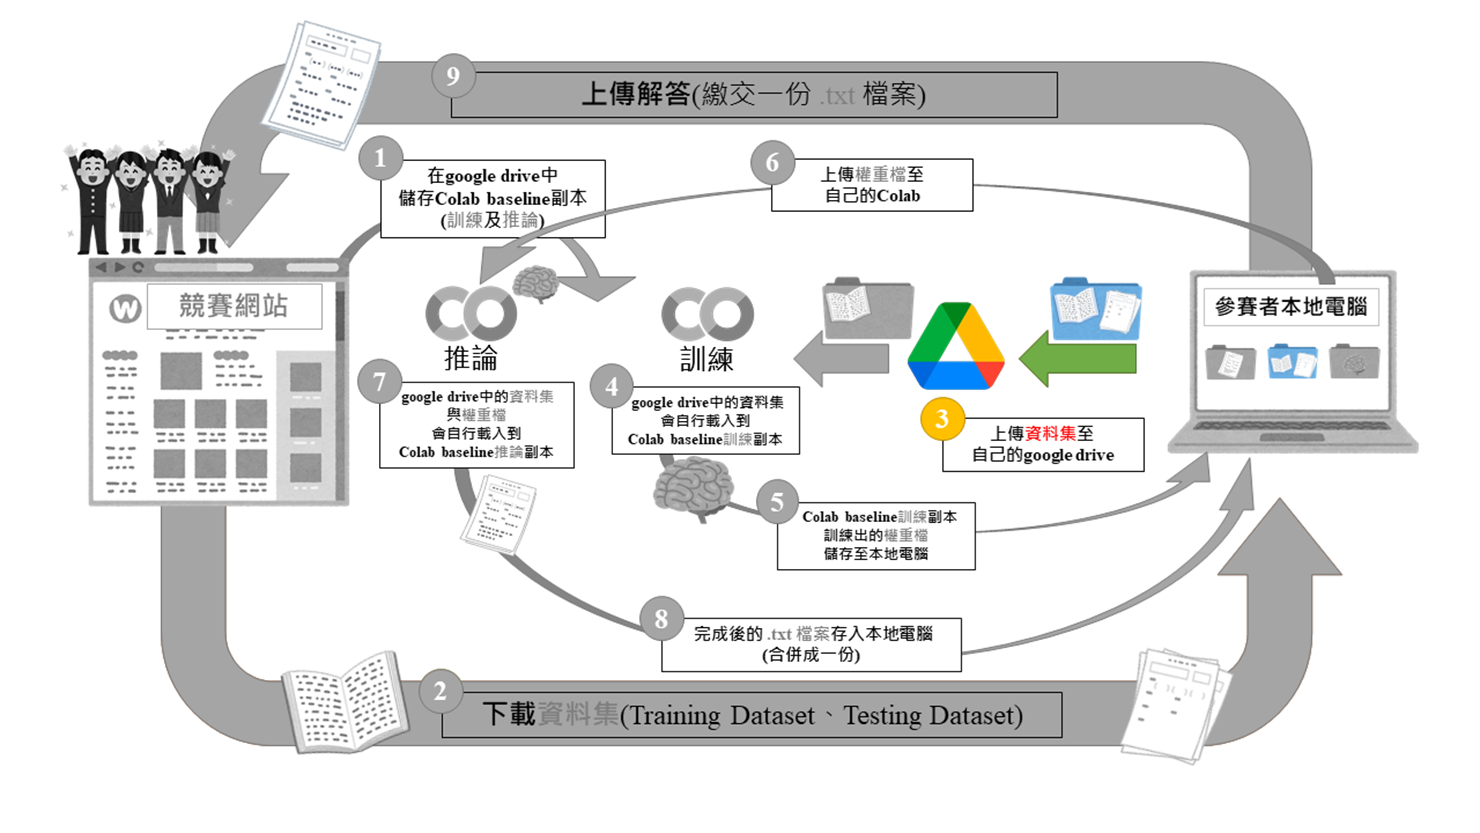

### 資料集
* testing_image.zip https://drive.google.com/file/d/1DB_y8RUOddn87MX_V6avOMOOb9D-3nEz/view?usp=sharing
* aortic_valve_colab.yaml https://drive.google.com/file/d/1wt9IGcnHki96sHvoVY96Td3vXhyw9Nhz/view?usp=sharing

In [ ]:
%%bash
mkdir ./datasets
mkdir ./datasets/test
gdown https://drive.google.com/uc?id=1DB_y8RUOddn87MX_V6avOMOOb9D-3nEz
unzip testing_image.zip -d /content/datasets/test/tmp
rm testing_image.zip

因為本競賽Testing資料集有16620張圖片，如果全部一起預測Colab的RAM會不足，所以將Testing圖片分成兩次做預測

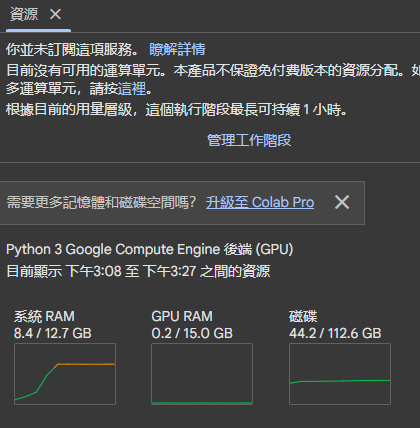

### 一半的圖片移至imges1資料夾，另一半移至imges2資料夾

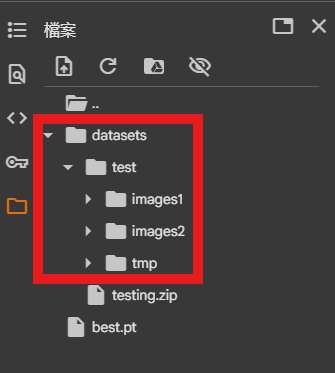

#=====================================================

In [ ]:
import os
import shutil

base_root = "/content/datasets/test/tmp"
dst_root1 = "/content/datasets/test/images1"
dst_root2 = "/content/datasets/test/images2"

os.makedirs(dst_root1, exist_ok=True)
os.makedirs(dst_root2, exist_ok=True)

# 自動找到第一個「直屬子資料夾含 patient*」的目錄
patient_root = base_root
for dirpath, dirnames, _ in os.walk(base_root):
    if any(d.lower().startswith("patient") for d in dirnames):
        patient_root = dirpath
        break

# 收集所有圖片路徑（只看直屬的 patient 資料夾）
all_files = []
for patient_folder in os.listdir(patient_root):
    patient_path = os.path.join(patient_root, patient_folder)
    if os.path.isdir(patient_path) and patient_folder.lower().startswith("patient"):
        for fname in os.listdir(patient_path):
            if fname.lower().endswith(".png"):
                all_files.append(os.path.join(patient_path, fname))

# 按名稱排序並對半移動
all_files.sort()
half = len(all_files) // 2

for f in all_files[:half]:
    shutil.move(f, os.path.join(dst_root1, os.path.basename(f)))

for f in all_files[half:]:
    shutil.move(f, os.path.join(dst_root2, os.path.basename(f)))

print(f"來源根目錄：{patient_root}")
print(f"完成移動！總共 {len(all_files)} 張，前半 {half} 張到 images1，後半 {len(all_files)-half} 張到 images2")


In [ ]:
print('測試集圖片數量 : ',len(os.listdir("./datasets/test/images1"))+len(os.listdir("./datasets/test/images2")))

## 3.Predict

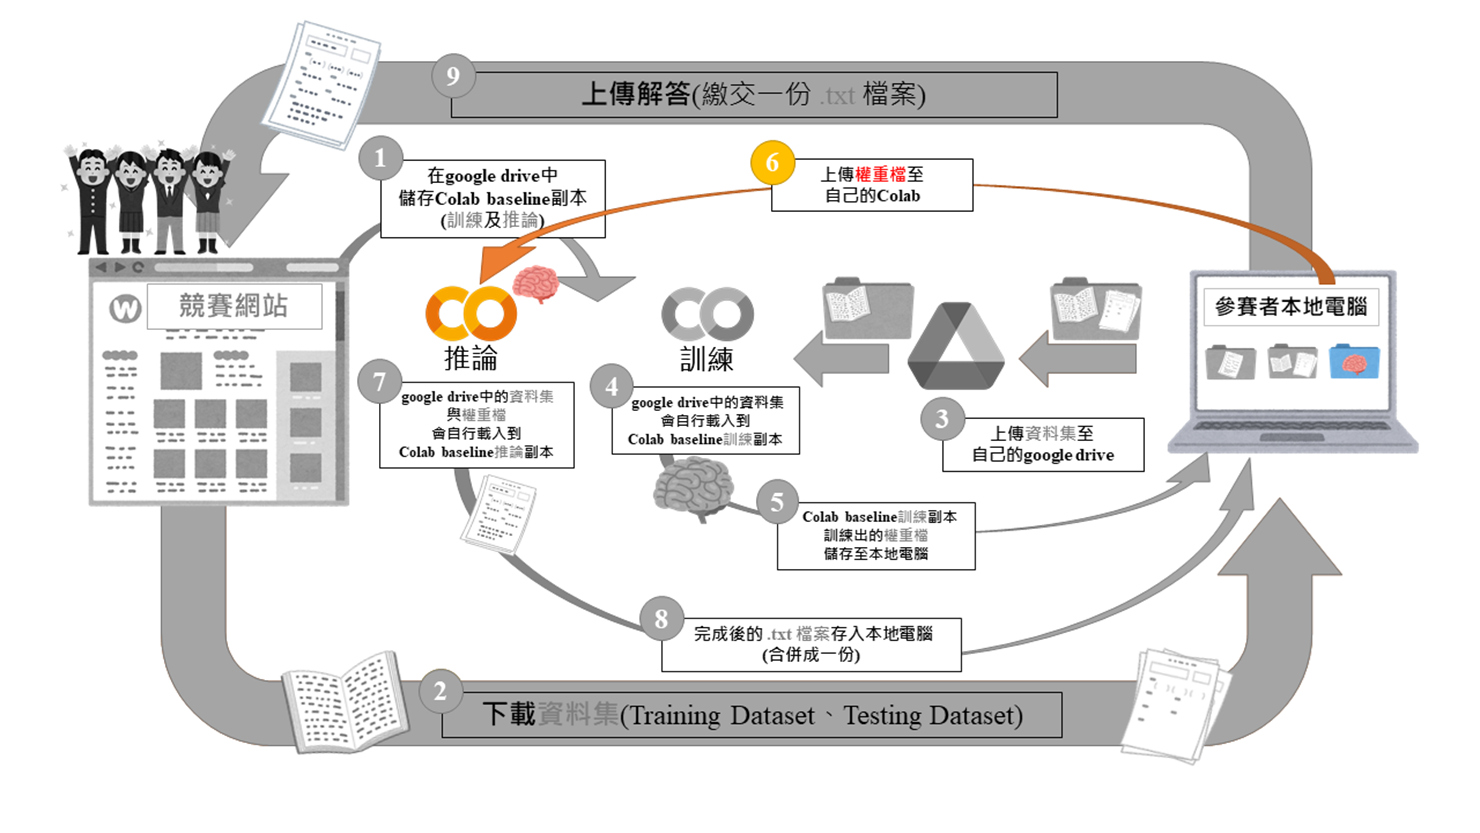

### Yolo12權重檔
* best.pt https://drive.google.com/file/d/1wvk7KDfnNAMt2fBlFCMOJoS78G0zARnt/view?usp=sharing
* last.pt https://drive.google.com/file/d/1V-jVBUziu1uIib8D3CfK1kYMu7_2EAVn/view?usp=sharing

In [ ]:
!gdown https://drive.google.com/uc?id=1wvk7KDfnNAMt2fBlFCMOJoS78G0zARnt

#使用自行訓練模型可透過拖移方式上傳至Colab

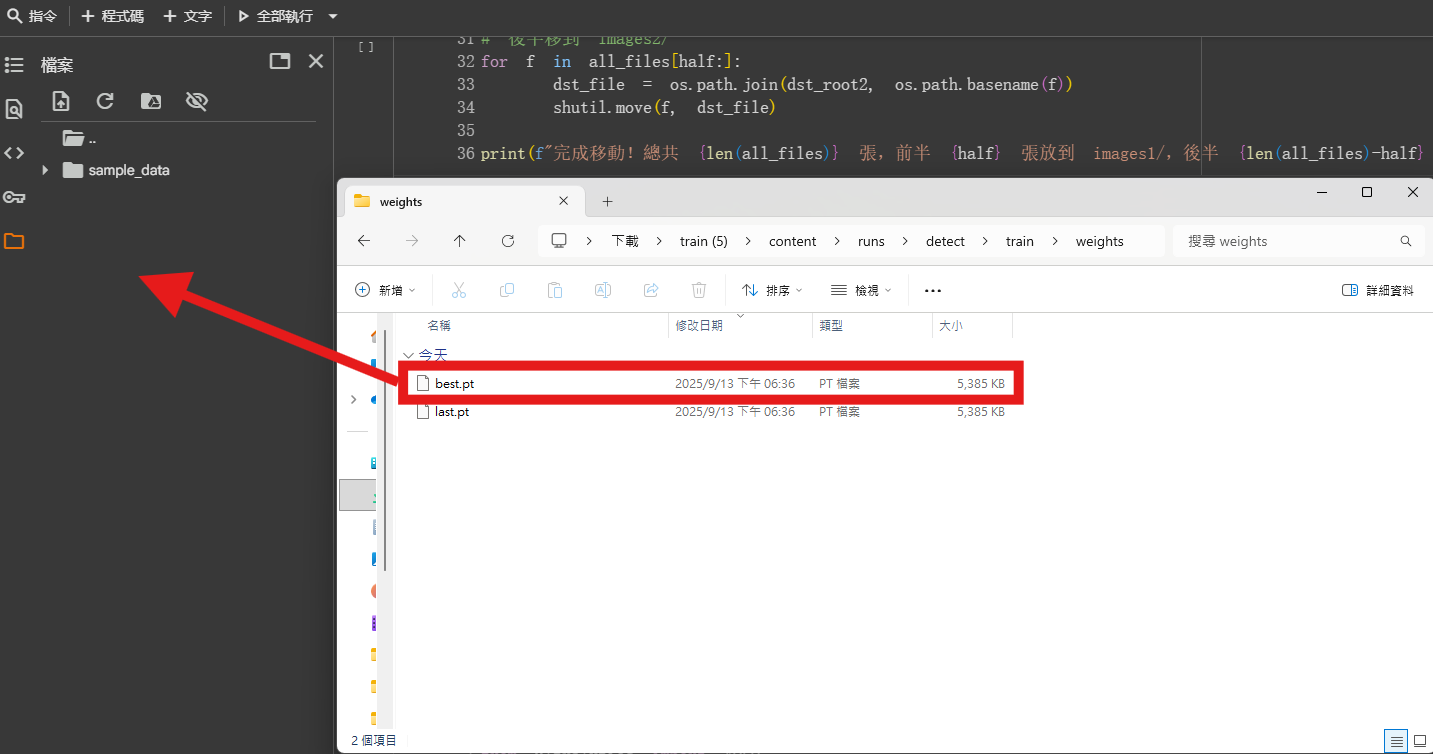

### 使用訓練過模型進行預測前半部分圖片(執行時間3分鐘)

In [ ]:
from ultralytics import YOLO
#模型參數參考網址:https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml
model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images1/",
              save=True,
              imgsz=640,
              device=0
              )

#predict資料夾內**有圖片代表預測完成**


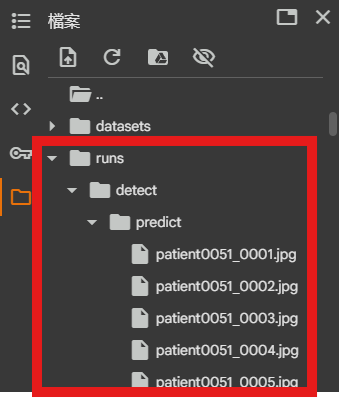

### 預測結果

In [ ]:
from IPython.display import Image

Image(filename='/content/runs/detect/predict/patient0051_0260.jpg', height=600)

###預測數量

In [ ]:
print(len(results))

### 預測結果的資訊

In [ ]:
print('預測類別 : ',results[260].boxes.cls[0].item())
print('預測信心分數 : ',results[260].boxes.conf[0].item())
print('預測框座標 : ',results[260].boxes.xyxy[0].tolist())

### 將偵測框數值寫進.txt檔

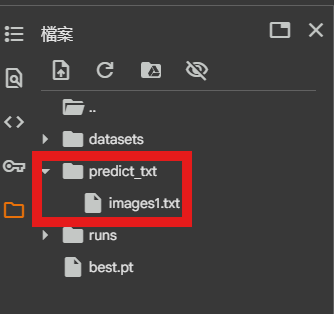

#=====================================================

In [ ]:
!mkdir ./predict_txt/
output_file = open('./predict_txt/images1.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


### 因為Colab RAM不會自動釋放，所以透過程式釋放

In [ ]:
import torch ,gc

# 刪除大型變數
del boxes,all_files,results
gc.collect()
torch.cuda.empty_cache()

## 預測後半圖片
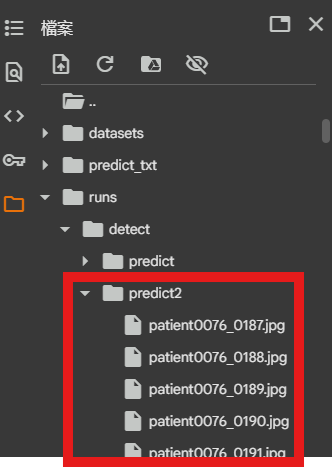

#=====================================================

In [ ]:
from ultralytics import YOLO
#模型參數參考網址:https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/default.yaml
model = YOLO('/content/best.pt')
results = model.predict(source="./datasets/test/images2/",
              save=True,
              imgsz=640,
              device=0
              )

### 將後半部分偵測框數值寫進.txt檔

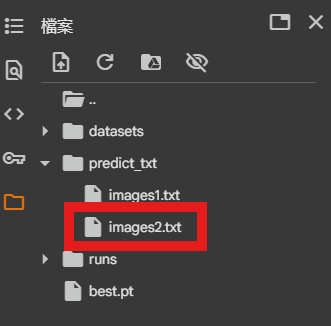

#=====================================================

In [ ]:
output_file = open('./predict_txt/images2.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()


### 合併兩個resut.txt->merged.txt

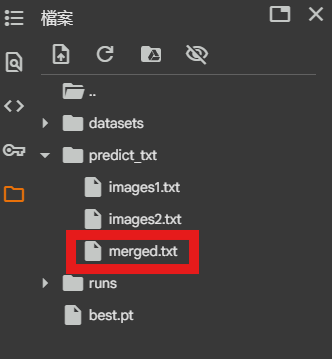

In [ ]:
file1 = "./predict_txt/images1.txt"
file2 = "./predict_txt/images2.txt"
output = "./predict_txt/merged.txt"

with open(output, "w", encoding="utf-8") as fout:
    for f in [file1, file2]:
        if os.path.exists(f):
            with open(f, "r", encoding="utf-8") as fin:
                fout.writelines(fin.readlines())

print(f"合併完成 -> {output}")


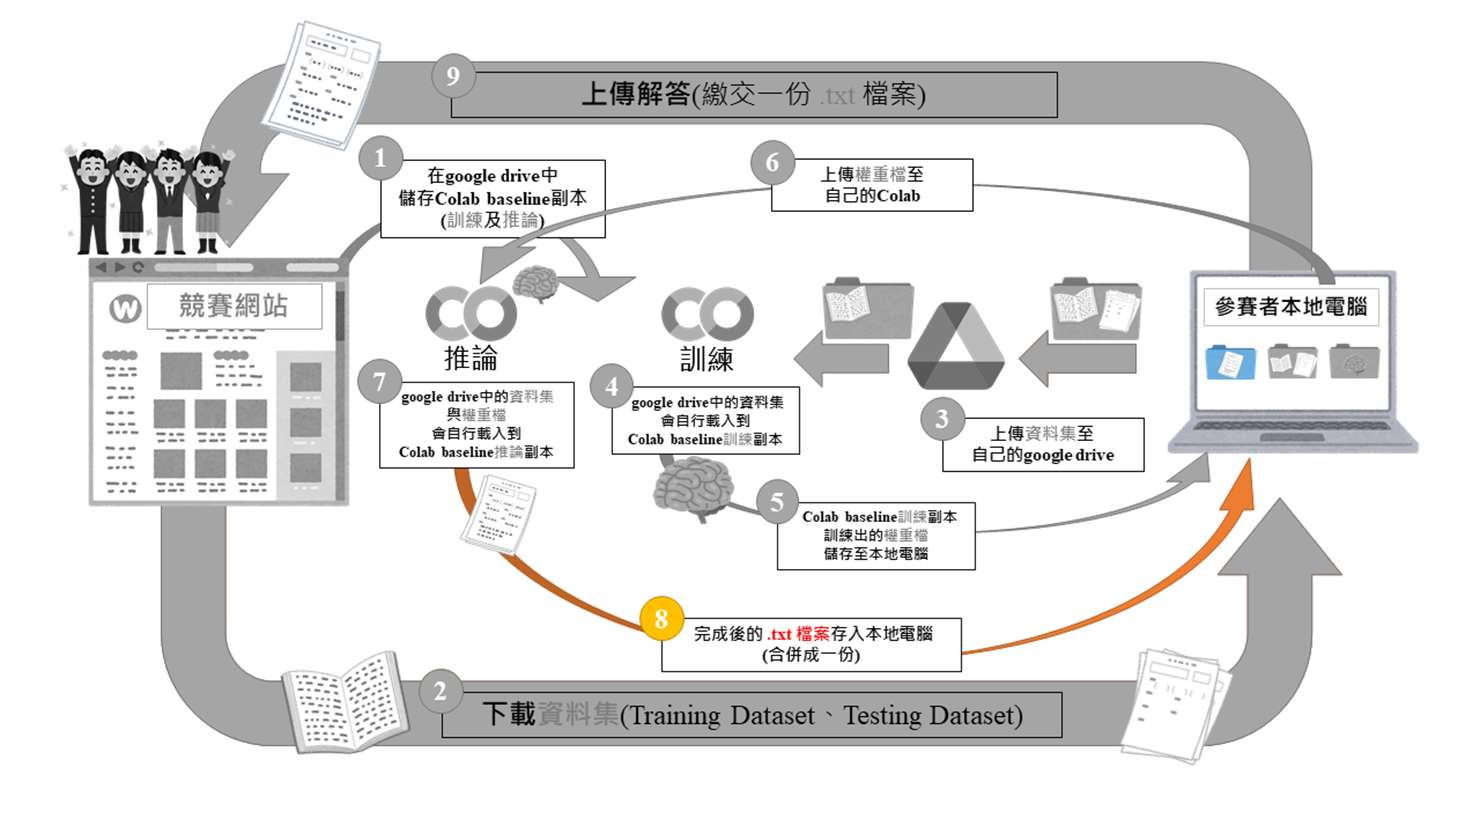

### 下載競賽提交txt

In [ ]:
from google.colab import files
files.download('/content/predict_txt/merged.txt')